# <b>1 <span style='color:#2ae4f5'>|</span> Importando Bibliotecas </b>

In [ ]:
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.utils import plot_model
import os

import matplotlib.pyplot as plt
#load mnist dataset

/Users/humbertotavora/Documents/UFPE/Deep Learning/Projeto de Pesquisa/DeepLearningProject/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# <b>2 <span style='color:#2ae4f5'>|</span> Dataset </b>

### MNIST Dataset

In [ ]:
# Setup train and test splits
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Training label shape: ", y_train.shape)  # (60000,)
print("First 5 training labels: ", y_train[:5])  # [5, 0, 4, 1, 9]

# Convert to "one-hot" vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Splitting dataset for faster learning and debugging
X_train, _, _, _, _, _ = np.split(X_train, 6)
y_train, _, _, _, _, _ = np.split(y_train, 6)

# Reshape the data for CNN (28, 28, 1)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

print(y_train.shape)
print(X_train.shape)

Training label shape:  (60000,)
First 5 training labels:  [5 0 4 1 9]
(10000, 10)
(10000, 28, 28, 1)


In [ ]:
nShapeSize = 28
nShape = 1

### Chest X-Ray Images (Pneumonia)

In [ ]:
# Define image size and other parameters
img_width, img_height = 256, 256
batchsize = 32
epochs = 4
num_classes = 2

train = keras.utils.image_dataset_from_directory(
    directory='chest_xray/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

test = keras.utils.image_dataset_from_directory(
    directory='chest_xray/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

print(train.class_names)
print(test.class_names)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


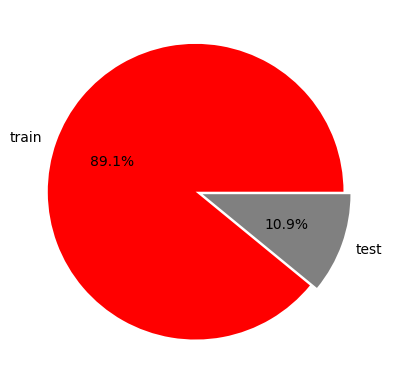

In [ ]:
plt.pie([len(train), len(test)],
        labels=['train','test'], autopct='%.1f%%', colors=['red', 'grey'], explode=(0.05, 0))
plt.show()

In [ ]:
# Extracting Features and Labels
x_train = []
y_train = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature.numpy())
    y_train.append(label.numpy())

for feature, label in test:
    x_test.append(feature.numpy())
    y_test.append(label.numpy())

# Concatenate the lists to get the full 'x' and 'y' arrays
x_train = np.concatenate(x_train, axis=0)
x_test = np.concatenate(x_test, axis=0)
y_train = np.concatenate(y_train, axis=0)
y_test = np.concatenate(y_test, axis=0)

# check the shapes of 'x_train' and 'y_train':
print("Shape of 'x_train':", x_train.shape)
print("Shape of 'y_train':", y_train.shape)
print("Shape of 'x_test':", x_test.shape)
print("Shape of 'y_test':", y_test.shape)

# Pixel Value Scaling for Datasets: Normalizing and Standardizing the Data
X_train=x_train/256
X_test=x_test/256

2024-12-11 15:42:19.506616: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:42:20.305594: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Shape of 'x_train': (5216, 256, 256, 3)
Shape of 'y_train': (5216, 2)
Shape of 'x_test': (624, 256, 256, 3)
Shape of 'y_test': (624, 2)


In [ ]:
nShapeSize = 256
nShape = 3

### Covid-19 Radiography Database

# <b>3 <span style='color:#2ae4f5'>|</span> Hiperparametros </b>

Hiperparamtros considerados na evolução:

* DNA[0] = depth
* DNA[1] = Kernel
* DNA[2] = filters per layer
* DNA[3] = activations
* DNA[4] = optimizer
* DNA[5] = losses
* DNA[6] = initializers


In [1]:
DNA_parameter = [
    [1, 2, 3],  # depth
    [(3, 3), (5, 5)],  # Kernel
    [32, 64, 128],  # filters per layer
    ["relu", "tanh", "sigmoid"],  # activations
    ["sgd", "adam"],  # optimizers
    ["categorical_crossentropy", "binary_crossentropy", "poisson"],  # loss functions
    ["he_normal", "glorot_uniform", None]  # initializers
]

# <b>4 <span style='color:#2ae4f5'>|</span> CNN </b>

In [ ]:
class Network:
    def __init__(self, input_shape, classes, DNA_param, epochs):
        self.architecture_DNA = []
        self.fitness = 0
        self.acc_history = []
        self.f1_history = []
        self.fitness_history = []
        self.input_shape = input_shape
        self.classes = classes
        self.epochs = epochs

        depth = DNA_param[0]
        network_depth = depth
        kernel_filter = DNA_param[1]

        self.architecture_DNA.append(depth)
        self.architecture_DNA.append(kernel_filter)

        model = Sequential()

        # Building the initial network with random choices
        initializer = DNA_param[2]  # Inicializador adicionado ao DNA
        self.architecture_DNA.append(initializer)

        for i in range(network_depth):
            filters = DNA_param[i+3][0]
            activation = DNA_param[i+3][1]

            self.architecture_DNA.append([filters, activation])

            if i == 0:
                model.add(Conv2D(filters, kernel_size=kernel_filter, activation=activation,
                                 kernel_initializer=initializer, input_shape=self.input_shape, padding='same'))
            else:
                model.add(Conv2D(filters, kernel_size=kernel_filter, activation=activation,
                                 kernel_initializer=initializer, padding='same'))

            model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(self.classes, activation='softmax', kernel_initializer=initializer))
        optimizer = DNA_param[-2]
        loss = DNA_param[-1]
        self.architecture_DNA.append(optimizer)
        self.architecture_DNA.append(loss)

        model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
        self.model = model

    @classmethod
    def from_random_DNA(cls, input_shape, classes, epochs):
        # Parâmetros globais de DNA
        depth_options = DNA_parameter[0]
        kernels_filters = DNA_parameter[1]
        filters_per_layer = DNA_parameter[2]
        activations = DNA_parameter[3]
        optimizers = DNA_parameter[4]
        losses = DNA_parameter[5]
        initializers = DNA_parameter[6]  # Inicializadores

        DNA_param = []

        # Escolhas aleatórias para cada parte do DNA
        network_depth = np.random.choice(depth_options)
        DNA_param.append(network_depth)

        kernel_filter_index = np.random.choice([kernel for kernel in range(len(kernels_filters))])
        kernel_filter = kernels_filters[kernel_filter_index]
        DNA_param.append(kernel_filter)

        # Escolher inicializador
        initializer = np.random.choice(initializers)
        DNA_param.append(initializer)

        for i in range(network_depth):
            filters = np.random.choice(filters_per_layer)
            activation = np.random.choice(activations)

            DNA_param.append([filters, activation])

        # Escolher otimizador e perda aleatoriamente

        optimizer = np.random.choice(optimizers)
        loss = np.random.choice(losses)

        DNA_param.append(optimizer)
        DNA_param.append(loss)

        # Retornar nova instância da classe com o DNA aleatório
        return cls(input_shape, classes, DNA_param, epochs)

    def create_children(self, children_DNA):
        model = Sequential()

        children_depth = children_DNA[0]
        kernel_filter = children_DNA[1]
        initializer = children_DNA[-3]  # Inicializador

        for i in range(children_depth):
            filters = children_DNA[i + 2][0]
            activation = children_DNA[i + 2][1]

            if i == 0:
                model.add(Conv2D(filters, kernel_size=kernel_filter, activation=activation,
                                 kernel_initializer=initializer, input_shape=self.input_shape, padding='same'))
            else:
                model.add(Conv2D(filters, kernel_size=kernel_filter, activation=activation,
                                 kernel_initializer=initializer, padding='same'))

            model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(self.classes, activation='softmax', kernel_initializer=initializer))
        model.compile(optimizer=children_DNA[-2], loss=children_DNA[-1], metrics=['accuracy'])
        self.model = model
        self.architecture_DNA = children_DNA

    def train(self):
        with tf.device('/GPU:0'):  # Garante que a GPU será utilizada
            self.model.fit(X_train, y_train, batch_size=32, epochs=self.epochs, verbose=1, shuffle=True)

    def test(self, alpha=0.8):
        with tf.device('/GPU:0'):
            loss, acc = self.model.evaluate(X_test, y_test, verbose=0)

        y_pred = self.model.predict(X_test)
        y_pred_classes = y_pred.argmax(axis=1)  # Obtém as classes previstas
        y_true_classes = y_test.argmax(axis=1)  # Converte one-hot para rótulos originais

        f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

        fitness = alpha * acc + (1 - alpha) * f1

        self.fitness = fitness
        self.acc_history.append(acc)
        self.f1_history.append(f1)
        self.fitness_history.append(fitness)

        print(f"Accuracy: {acc}, F1-Score: {f1}, Fitness: {fitness}")

    def give_DNA(self):
        return self.architecture_DNA

    def architecture(self):
        self.model.summary()


# <b>5 <span style='color:#2ae4f5'>|</span> Algoritmo Genético </b>

In [ ]:
class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, generations=50, epochs=2):
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.training_epochs = epochs
        self.population_size = population_size
        self.best_model = None
        self.best_DNA = None
        self.individuals_count = 0
        self.error_count = 0
        self.best_fitness_history = []
        self.mean_fitness_history = []
        self.cache = []
        self.model_map = {}
        self.fitness_map = {}
        self.best_fitness = -1  # Fitness inicial negativo para garantir atualização

    def create_population(self):
        for i in range(1,self.population_size+1):
            individuo = "Individuo " + str(i)
            success = False
            while not success:
                try:
                    self.model_map[individuo] = Network.from_random_DNA((nShapeSize, nShapeSize, nShape), num_classes, self.training_epochs)
                    self.individuals_count +=1
                    i += 1
                    success = True
                except Exception as e:
                    self.error_count += 1

    def create_childrens(self, parent1, parent2):

        cross_child1_DNA = self.crossover(parent1, parent2)
        child1_DNA = self.mutate(cross_child1_DNA)
        cross_child2_DNA = self.crossover(parent2, parent1)
        child2_DNA = self.mutate(cross_child2_DNA)

        child1 = Network((nShapeSize, nShapeSize, nShape), num_classes, child1_DNA, self.training_epochs)
        self.individuals_count +=1
        individuoChild1 = "Individuo " + str(self.individuals_count)
        self.model_map[individuoChild1] = child1


        child2 = Network((nShapeSize, nShapeSize, nShape), num_classes, child2_DNA, self.training_epochs)
        self.individuals_count +=1
        individuoChild2 = "Individuo " + str(self.individuals_count)
        self.model_map[individuoChild2] = child2

    def show_individuos(self):
        for _ , individuo in self.model_map.items():
            print(individuo.give_DNA())
        print("\n")

    def show_individuos_maps(self):
        for individuo, fitness in self.fitness_map.items():
            print(f"{individuo}: {fitness} {self.model_map[individuo].give_DNA()}")
        print("\n")

    def show_mean_trajetory_fitness(self):

        generations = len(self.mean_fitness_history)
        generations_range = range(1, generations + 1)

        # Geração do gráfico
        plt.figure(figsize=(10, 5))

        # Plota o progresso do fitness ao longo das gerações
        plt.plot(generations_range, self.mean_fitness_history, marker='*', color='magenta', linestyle='--', label='Mean Fitness')

        # Configurações do gráfico
        plt.xlabel("The number of generations")
        plt.ylabel("Classification accuracy")
        plt.title("Trajectory of the Mean Fitness Over Generations")
        plt.legend()
        plt.grid(True)

        # Exibe o gráfico
        plt.tight_layout()
        plt.show()

    def show_best_fitness_trajectory(self):
        generations = len(self.best_fitness_history)
        generations_range = range(1, generations + 1)

        # Geração do gráfico
        plt.figure(figsize=(10, 5))

        # Plota o progresso do melhor fitness ao longo das gerações
        plt.plot(generations_range, self.best_fitness_history, marker='o', color='blue', linestyle='-', label='Best Fitness')

        # Configurações do gráfico
        plt.xlabel("The number of generations")
        plt.ylabel("Best fitness")
        plt.title("Trajectory of the Best Fitness Over Generations")
        plt.legend()
        plt.grid(True)

        # Exibe o gráfico
        plt.tight_layout()
        plt.show()

    def train_generation(self):
        individuos = self.model_map.keys()
        for individuo in individuos:
            if(not(individuo in self.cache)):
                print(individuo, " treinamento:")

                try:
                    self.model_map[individuo].train()
                except Exception as e:
                    continue

    def fintess_calculation(self):
        individuos = self.model_map.keys()
        for individuo in individuos:
            if(not(individuo in self.cache)):
                print(individuo, " teste para calculo de fitenss:")
                try:
                    self.model_map[individuo].test()
                except Exception as e:
                    self.model_map[individuo].fitness = 0
                self.fitness_map[individuo] = self.model_map[individuo].fitness
                self.cache.append(individuo)

    def select_parents(self):
        individuos = list(self.fitness_map.keys())
        fitness = np.array(list(self.fitness_map.values()))

        # Normaliza os fitnesses para criar uma distribuição de probabilidades
        probabilidades = fitness / fitness.sum()

        # Seleciona os indivíduos com maior probabilidade conforme o fitness
        selecionados = np.random.choice(individuos, size=2, p=probabilidades, replace=False)

        return [self.model_map[selecionados[0]], self.model_map[selecionados[1]]]

    def select_survivors(self):
        individuos = list(self.fitness_map.keys())
        fitness = np.array(list(self.fitness_map.values()))

        # Normaliza os fitnesses para criar uma distribuição de probabilidades
        probabilidades = fitness / fitness.sum()

        # Seleciona os indivíduos com maior probabilidade conforme o fitness
        selecionados = np.random.choice(individuos, size=self.population_size, p=probabilidades, replace=False)

        # Constrói o dicionário com os indivíduos selecionados e seus respectivos fitnesses
        self.fitness_map = {individuo: self.fitness_map[individuo] for individuo in selecionados}
        self.model_map = {individuo: self.model_map[individuo] for individuo in selecionados}

    def crossover(self, parent1, parent2):
        dna1 = parent1.give_DNA()
        dna2 = parent2.give_DNA()
        child_DNA = []

        # Seleciona profundidade (depth) do DNA dos pais
        child_DNA.append(dna1[0])

        # Seleciona kernel (filter) do DNA dos pais
        child_DNA.append(dna1[1])

        # Seleciona inicializador do DNA dos pais
        child_DNA.append(dna1[2])

        for i in range(dna1[0]):
            filters = dna1[i+3][0]
            activation = dna1[i+3][1]
            child_DNA.append([filters, activation])

        # Seleciona otimizador, e função de perda

        child_DNA.append(dna2[-2])
        child_DNA.append(dna2[-1])

        #print("Crossover DNA:", child_DNA)  # Debug para verificar o DNA após mutação


        return child_DNA

    def give_DNA(self):
        print("DNA:", self.architecture_DNA)  # Adicione este print para depuração
        return self.architecture_DNA

    def mutate(self, dna):
        copyDNA = dna.copy()
        mutated_DNA = []
        # Mutação para profundidade, filtros e função de ativação, garantindo uma lista de mesmo comprimento que profundidade
        if np.random.rand() < self.mutation_rate:
            mutated_DNA.append(np.random.choice(DNA_parameter[0]))

            kernel_filter_index = np.random.choice([kernel for kernel in range(len(DNA_parameter[1]))])
            kernel_filter = DNA_parameter[1][kernel_filter_index]
            mutated_DNA.append(kernel_filter)

            mutated_DNA.append(np.random.choice(DNA_parameter[6]))


            for i in range(mutated_DNA[0]):
                filters = np.random.choice(DNA_parameter[2])
                activation = np.random.choice(DNA_parameter[3])
                mutated_DNA.append([filters, activation])
        else:
            mutated_DNA.append(copyDNA[0])
            mutated_DNA.append(copyDNA[1])
            mutated_DNA.append(copyDNA[2])
            for i in range(copyDNA[0]):
                filters = copyDNA[i + 3][0]
                activation = copyDNA[i + 3][1]
                mutated_DNA.append([filters, activation])

        # Alteração de optimizer
        if np.random.rand() < self.mutation_rate:
            mutated_DNA.append(np.random.choice(DNA_parameter[4]))
        else:
            mutated_DNA.append(copyDNA[-2])

        # Alteração de loss
        if np.random.rand() < self.mutation_rate:
            mutated_DNA.append(np.random.choice(DNA_parameter[5]))
        else:
            mutated_DNA.append(copyDNA[-1])


        #print("Mutated DNA:", mutated_DNA)  # Debug para verificar o DNA após mutação
        return mutated_DNA

    def evolve(self, max_fitness):
        self.create_population()
        self.show_individuos()
        print(f"\nGeração 0")
        print("Treinamento:")
        self.train_generation()
        print("\n")
        print("Teste:")
        self.fintess_calculation()
        print("\n")
        print(self.individuals_count)
        for generation in range(self.generations):
            print(f"\nGeração {generation + 1}")
            # Atualiza a melhor rede se o fitness atual for o maior até o momento
            melhor_individuo = max(self.fitness_map, key=self.fitness_map.get)
            max_current_fitness = self.fitness_map[melhor_individuo]
            if max_current_fitness > self.best_fitness:
                self.best_fitness = max_current_fitness
                self.best_model = self.model_map[melhor_individuo].model
                self.best_DNA = self.model_map[melhor_individuo].give_DNA()
                print(f"Novo melhor modelo com fitness: {self.best_fitness}")

            fitness_values = list(self.fitness_map.values())  # Extrai os valores de fitness
            fitness_mean = np.mean(fitness_values)  # Calcula a média
            print(fitness_mean,max_current_fitness)
            self.show_individuos_maps()

            self.best_fitness_history.append(self.best_fitness)
            self.mean_fitness_history.append(fitness_mean)



            # Verifica se o fitness máximo foi alcançado
            if max_current_fitness >= max_fitness:
                print(f"Critério de parada atingido: fitness máximo desejado ({max_fitness})")
                break

            parent1, parent2 = self.select_parents()
            print(parent1.give_DNA(),parent2.give_DNA())
            self.create_childrens(parent1,parent2)
            print(self.individuals_count)
            print("\nTreinamento:")
            self.train_generation()
            print("\n")
            print("Teste:")
            self.fintess_calculation()
            print("\n")
            self.show_individuos_maps()

            self.select_survivors()
            print(self.individuals_count)

            #self.show_individuos_maps()
        # Exporta o modelo da melhor combinação
        if self.best_model:
            self.show_mean_trajetory_fitness()
            self.show_best_fitness_trajectory()
            print(f"Melhor combinação de DNA: {self.best_DNA} com fitness: {self.best_fitness}")
            self.best_model.save('my_model.keras')
            print("Modelo da melhor combinação exportado como 'melhor_modelo.h5'")

            if not os.path.exists("visualizations"):
                os.makedirs("visualizations")
            plot_model(self.best_model, to_file="visualizations/best_model_architecture.png", show_shapes=True)
            print("Diagrama da arquitetura salvo em 'visualizations/best_model_architecture.png'")


# <b>5 <span style='color:#2ae4f5'>|</span> Evolução </b>

In [ ]:
fitness_goal = 0.95

GA = GeneticAlgorithm(population_size=5, mutation_rate=0.2, generations=15, epochs=5)
GA.evolve(fitness_goal)